# Load Profile Forecasting

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
data = pd.read_csv("./data/data_oct20.csv", parse_dates = ["date"])
data = data.iloc[::10]
data.head(2)

,L2_react,L2,L,L_react,NS4949_export,L2_active_import,PV,Wind_speed,Temperature,Global_irradiance,Plane_irradiance,Module_temp,Bat_current,Bat_energy,Battery_SOC,Battery_voltage,Battery_charge,Battery_discharge,date,L1
0,-1.672253,8.917166,105.823796,-1.330095,103.75,7.500,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,2020-10-01 01:00:00,96.906629
10,-1.528216,6.749649,99.311711,1.809572,115.00,5.625,0.037092,3.0,13.221428,0.179641,0.180723,0.001712,-0.714286,761.702393,69.599998,751.555542,0.000416,0.000313,2020-10-01 01:10:00,92.562062


## Step 1 - Statistical Properties

After the cleaning the timeseries is
1. Discrete
2. Evenly sampled

We will see if the timesseries is: 
1. Multivariate or univariate
2. Periodic or aperiodic
3. Stationary or nonstationary


### Multivariate vs. univariate


[]

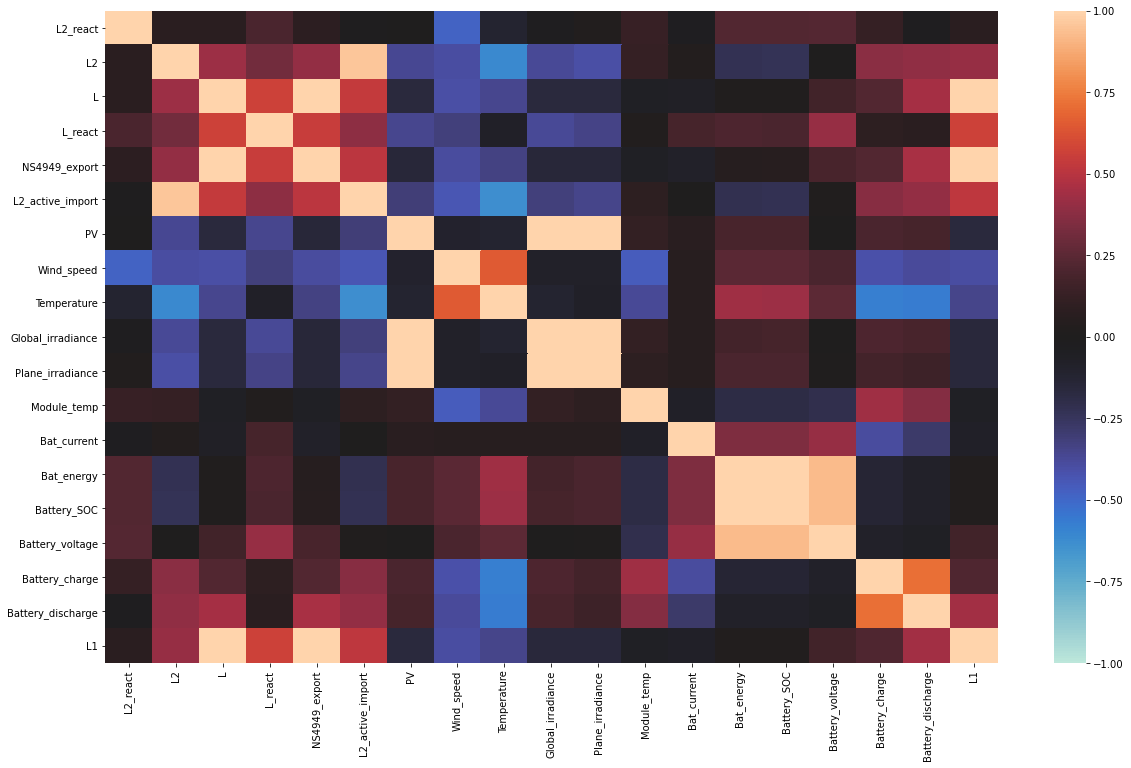

In [6]:
corr = data.groupby(data.date.dt.day).mean().corr()

plt.figure(figsize = (20, 12))
sn.heatmap(corr, vmin = -1, vmax = 1, center = 0)
plt.plot()

In [7]:
corr

,L2_react,L2,L,L_react,NS4949_export,L2_active_import,PV,Wind_speed,Temperature,Global_irradiance,Plane_irradiance,Module_temp,Bat_current,Bat_energy,Battery_SOC,Battery_voltage,Battery_charge,Battery_discharge,L1
L2_react,1.000000,0.070878,0.075935,0.201017,0.081003,-0.014114,-0.002057,-0.477970,-0.116753,-0.021690,0.023463,0.127228,-0.026691,0.222152,0.221317,0.229761,0.118223,-0.018546,0.075195
L2,0.070878,1.000000,0.424893,0.312941,0.402220,0.956300,-0.362797,-0.392560,-0.614843,-0.368410,-0.402610,0.121623,0.034060,-0.223567,-0.228714,0.001126,0.378517,0.391614,0.409346
L,0.075935,0.424893,1.000000,0.566424,0.998018,0.535870,-0.162164,-0.400759,-0.352892,-0.161170,-0.162418,-0.056223,-0.070308,0.021070,0.022778,0.167844,0.220884,0.449055,0.999854
L_react,0.201017,0.312941,0.566424,1.000000,0.552678,0.383424,-0.352526,-0.316613,-0.075699,-0.369083,-0.343127,0.024477,0.184537,0.205456,0.199677,0.407230,0.087347,0.076964,0.564975
NS4949_export,0.081003,0.402220,0.998018,0.552678,1.000000,0.514054,-0.143328,-0.385783,-0.335002,-0.141950,-0.143354,-0.059803,-0.083697,0.054190,0.056373,0.194897,0.221345,0.454540,0.998284
L2_active_import,-0.014114,0.956300,0.535870,0.383424,0.514054,1.000000,-0.307235,-0.432110,-0.627129,-0.313566,-0.345057,0.086138,0.006317,-0.215897,-0.220542,0.016641,0.368421,0.405477,0.522024
PV,-0.002057,-0.362797,-0.162164,-0.352526,-0.143328,-0.307235,1.000000,-0.095269,-0.115571,0.998570,0.994655,0.115541,0.069798,0.189170,0.194439,0.007143,0.202463,0.185792,-0.156587
Wind_speed,-0.477970,-0.392560,-0.400759,-0.316613,-0.385783,-0.432110,-0.095269,1.000000,0.649381,-0.080606,-0.081294,-0.458586,0.062173,0.248253,0.248749,0.196433,-0.408616,-0.381794,-0.396500
Temperature,-0.116753,-0.614843,-0.352892,-0.075699,-0.335002,-0.627129,-0.115571,0.649381,1.000000,-0.113152,-0.073350,-0.373377,0.055130,0.430145,0.428882,0.255801,-0.573361,-0.567506,-0.344056
Global_irradiance,-0.021690,-0.368410,-0.161170,-0.369083,-0.141950,-0.313566,0.998570,-0.080606,-0.113152,1.000000,0.993220,0.114815,0.060565,0.175721,0.181639,-0.003731,0.206716,0.189689,-0.155479


In [8]:
def extract_timeperiod(data, start, end):
    return data[(data.date >= start) & (data.date <=end)]

<Figure size 1440x720 with 0 Axes>

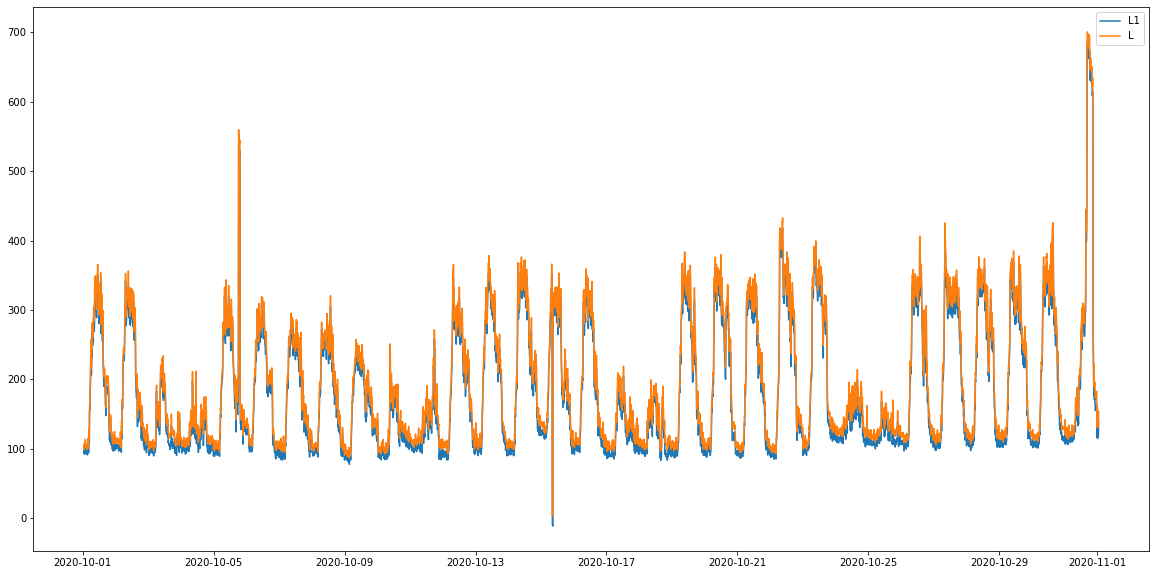

In [9]:
def plot_series_in_df(df, series):
    t = df.date
    plt.figure(figsize = (20, 10))
    for serie in series:
        plt.plot(t, df[serie].values)
        
    plt.legend(series)

plt.figure(figsize = (20, 10))
plot_series_in_df(data, ["L1", "L"])

In [10]:
class Load:
    def __init__(self, N, train_file, column, actions_per_hour=6, groundtruth=None):
        self.N = N
        self.groundtruth = groundtruth
        self.train_file = train_file
        self.resolution = 60 / actions_per_hour
        self.column = column

        self.df = pd.read_csv(self.train_file, parse_dates=["date"])
        self.mean = self.get_mean_day()
    


        if isinstance(groundtruth, pd.Series):
            self.true = self.groundtruth.values
        elif isinstance(groundtruth, pd.DataFrame):
            self.true = self.groundtruth[column].values
        elif isinstance(groundtruth, str):
            self.true = pd.read_csv(self.groundtruth)[self.column].values

            

    def get_mean_day(self):
        """
        Extracts the days and returns the average day
        """

        num_datapoints = 24 * 60 / self.resolution
        days = []
        grouped = self.df.groupby([self.df.date.dt.floor("d")], as_index=False)
        for _, group in grouped:
            if len(group) != num_datapoints:
                continue
            days.append(group[self.column].values)


        return np.asarray(days).mean(axis=0)

    def get_prediction_mean(self, step):
        """
        Returns the mean for the next N steps
        """
        return self.mean[step : step + self.N]

    def get_scaled_mean(self, measurement, step):
        """
        Returns the mean for the next N steps, scaled to current measurement
        """
        pred = (measurement / self.mean[step]) * self.mean[step : step + self.N]
        return pred
    
    def get_constant_pred(self, measurement, step):
        """
        Returns the current measurement as prediction for N
        """
        return measurement*np.ones(self.N)

    def get_groundtruth(self, step):
        if self.groundtruth is None:
            print("Groundtruth not provided")
            raise ValueError

        return self.true[step : step + self.N]


### Extract the errors for each timestep.

The chosen prediction method is tested for every day, and all errors for all timesteps are collected. To make the errors more readable, they are divided by the the groundtruth to get the percentage error.

In [26]:
def calculate_errors_for_day(column, num_steps, groundtruth):
    
    l = Load(num_steps, "./data/loads_train.csv", column, groundtruth=groundtruth)
    errors = []
    for step in range(groundtruth.shape[0]-num_steps):
        gt = l.get_groundtruth(step)
        pred = l.get_constant_pred(gt[0], step)
        errors.append(((pred-gt)/gt)[1:])
    return np.asarray(errors)
    
def calculate_errors(data, column, num_steps):
    
    grouped = data.groupby(data.date.dt.day)
    day_errors = []
    for day, df in grouped:
        day_error = calculate_errors_for_day(column, num_steps, df[column])
        day_errors.append(day_error)
    return np.asarray(day_errors)
    
        
errors = calculate_errors(data, "L", 13)

/Users/theo/anaconda3/envs/ml36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [27]:
plt.figure(figsize = (20, 10))
for step in range(errors.shape[1]):
    plt.scatter(range(step, step + errors.shape[2]), errors[3][step])

IndexError: tuple index out of range

<Figure size 1440x720 with 0 Axes>

Then the errors for each timestep in the prediction horizion is extracted. Note that we do not make a difference on time of day.

In [23]:
import time
dist = []
error_df = pd.DataFrame()
for k in range(errors.shape[2]):
    num_bins = 200
    
    err = errors[:,:,k].flatten()
    error_df[k+1] = errors[:,:,k].flatten()
    std = np.std(err)
    mean = np.mean(err)
    sigma = np.var(err)
    dist.append([mean, std])
    
    """
    x = np.linspace(mean - 3*sigma, mean + 3*sigma, num_bins)
    print("Prediction step:", k)
    print("Standard deviation:", std)
    print("Mean:", mean)
    

    plt.hist(err, bins = num_bins)
    plt.plot(x, stats.norm.pdf(x, mean, sigma))
    plt.show()
    time.sleep(0.2)
    """
error_df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12
count,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000
mean,0.018838,0.038114,0.068034,0.073285,0.074842,0.074416,0.077667,0.079649,0.081397,0.081524,0.083228,0.084748
std,1.035812,1.535929,2.301928,2.445338,2.453408,2.291778,2.281391,2.273286,2.238329,2.094499,2.032750,1.960649
min,-0.990786,-0.990680,-0.990779,-0.990433,-0.990296,-0.990886,-0.990934,-0.990409,-0.990238,-0.990916,-0.991115,-0.990796
25%,-0.042061,-0.054507,-0.063027,-0.069680,-0.070902,-0.076512,-0.082323,-0.080122,-0.086014,-0.089935,-0.097479,-0.099296
50%,0.000874,0.001009,0.002296,0.003119,0.006408,0.006802,0.010414,0.014139,0.013152,0.015000,0.016043,0.019279
75%,0.044386,0.055914,0.067030,0.077546,0.082174,0.090797,0.100656,0.113055,0.119859,0.133218,0.140216,0.150958
max,65.757143,76.758916,99.481568,116.041226,122.754463,108.723694,105.812888,109.300500,110.540589,99.351323,98.448827,96.691339


Now we plot the box plot with the errors in percentage on the y axis, and the timestep on xaxis. We can observe that the mean is centered around zero, and there is a wider spread the further into the predictions we get.

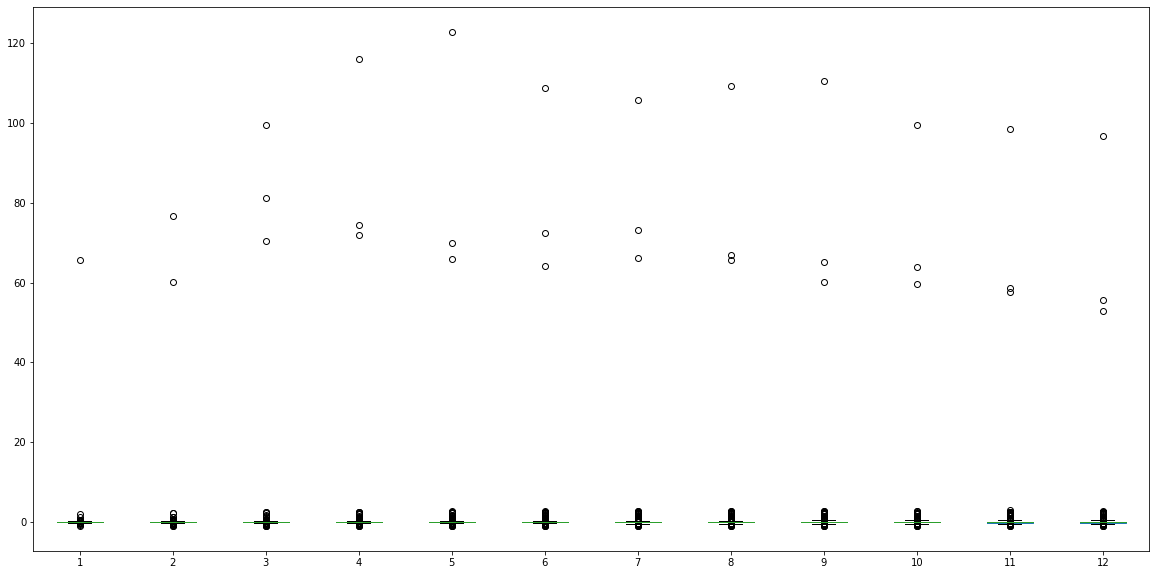

In [24]:
plt.show(error_df.plot.box(figsize = (20,10)))

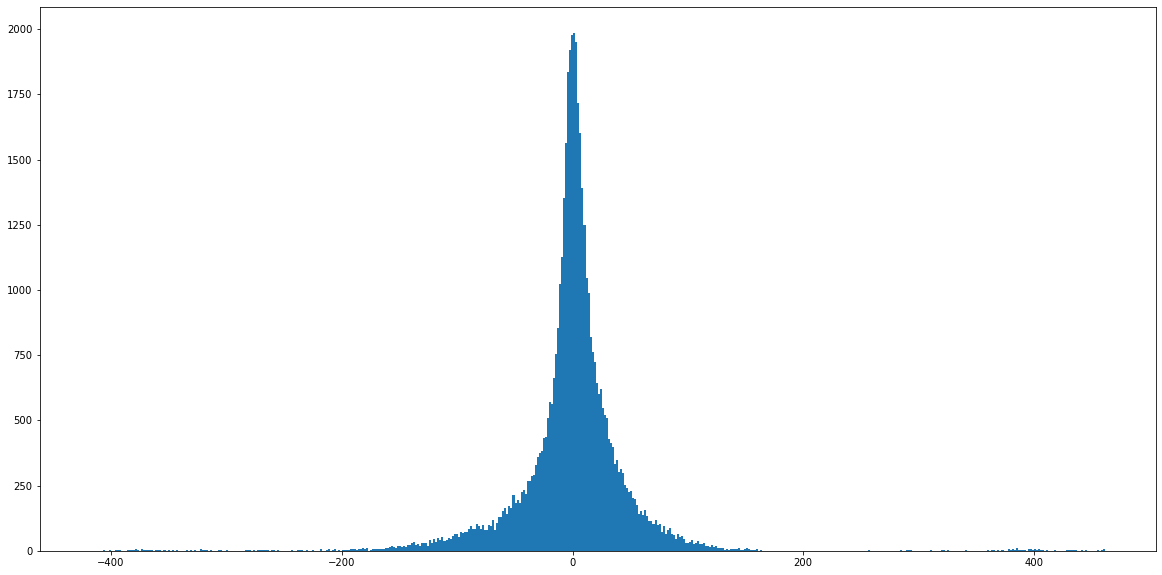

In [19]:
def plot_error_hist(errors):
    plt.figure(figsize = (20, 10))
    plt.hist(errors.flatten(), bins = 500)
    

plot_error_hist(errors)

#### Statistical tests
We wish to test if the data is normally distributed, and to do this we use the Lilliefors test [(Wikipedia)](https://en.wikipedia.org/wiki/Lilliefors_test). The advantage of this test is that it does not specify which normal distribution, meaning we dont have to make assumptions around mean and variance. If 

In [22]:
from statsmodels.stats.diagnostic import lilliefors

print("Lilliefors Test")
for i in range(1,13):
    print("P-Value at step {}: {}".format(i, lilliefors(error_df[i], dist = "norm")[1]))

Lilliefors Test
P-Value at step 1: 0.0009999999999998899
P-Value at step 2: 0.0009999999999998899
P-Value at step 3: 0.0009999999999998899
P-Value at step 4: 0.0009999999999998899
P-Value at step 5: 0.0009999999999998899
P-Value at step 6: 0.0009999999999998899
P-Value at step 7: 0.0009999999999998899
P-Value at step 8: 0.0009999999999998899
P-Value at step 9: 0.0009999999999998899
P-Value at step 10: 0.0009999999999998899
P-Value at step 11: 0.0009999999999998899
P-Value at step 12: 0.0009999999999998899


In [23]:
from scipy.stats import kstest

print("Kolmogorov–Smirnov Test")
for i in range(1,13):
    print("P-Value at step {}: {}".format(i, kstest(error_df[i], "norm")[1]))

Kolmogorov–Smirnov Test
P-Value at step 1: 0.0
P-Value at step 2: 0.0
P-Value at step 3: 0.0
P-Value at step 4: 0.0
P-Value at step 5: 0.0
P-Value at step 6: 0.0
P-Value at step 7: 0.0
P-Value at step 8: 0.0
P-Value at step 9: 0.0
P-Value at step 10: 0.0
P-Value at step 11: 0.0
P-Value at step 12: 0.0


The statistical tests fails, so we cannot assume the errors are normally distributed. Therefore we cannot fit a normal distribution. This makes sense as the error depends on time of day.

### Perodicness

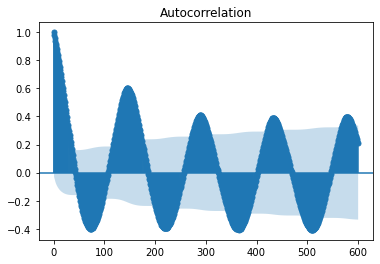

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(data["L"], lags = 600)
plt.show()